# PAPER 1

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import json 
from nilearn import plotting
import seaborn as sns 
from utils import OUT_PATH, FREQ_BAND, ExcludSubj, GetInfo, FindRegion, CompoThr
from utils import DataTransformationM1
from scipy.stats import spearmanr

tfr_path = OUT_PATH+ '/Data_shortWOBS'
subj_included = [file.replace('_TFRtrials.p', '') for file in os.listdir(tfr_path) if file[-len('TFRtrials.p'):] == 'TFRtrials.p']
subj_included = ExcludSubj(subj_included, data_path=tfr_path)
print(f"Subject Nbr is {len(subj_included)}")

coord, areas, elect_list, subj_list = GetInfo(subj_included, data_path=tfr_path)
regions = [FindRegion(a[0]) for a in areas]

with open(tfr_path + f'/{subj_included[0]}_info.json') as json_data:
    d = json.load(json_data)
    time = d['time_tfr']

plt.style.use('seaborn-v0_8-dark')

colors = plt.get_cmap('tab10')
element_colors = {elem: colors((i+3)**3 + 50) for i, elem in enumerate(FREQ_BAND)}


Subject Nbr is 30


## Band Power Extraction -- Quick method to got PCA + Decoding

## Brief summary of the result 
All freq band time series, topomap, decoding algo

## Low frequency band dynamics:  theta Power goes up, alpha goes down

time serie + topomap + timeming

In [3]:
compo = pd.read_csv(OUT_PATH + '/grpPCA/supsubj_concat/grp_concat_Compo_PCA3.csv').drop(columns = 'Unnamed: 0')
transform = pd.read_csv(OUT_PATH +  '/grpPCA/supsubj_concat/grp_concat_Xtrans_PCA3.csv')

/tmp/ipykernel_28323/1611502141.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1][1].legend(bbox_to_anchor = (1, 1))


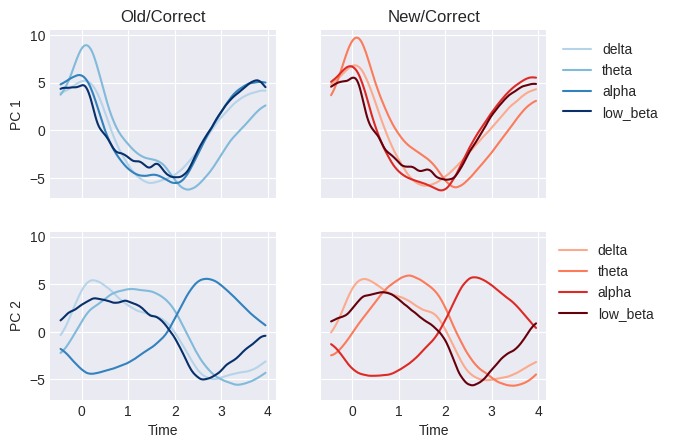

In [4]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
colors = plt.get_cmap('Blues')
element_colors_1 = {elem: colors((i+3)**3 + 50) for i, elem in enumerate(FREQ_BAND)}
colors = plt.get_cmap('Reds')
element_colors_2 = {elem: colors((i+3)**3 + 50) for i, elem in enumerate(FREQ_BAND)}

for ic, c in enumerate(['compo1', 'compo2']) :
    for band in FREQ_BAND[:4] : 
        time_serie = transform.query('freq == @band and compo == @c').drop(columns = ['Unnamed: 0', 'freq' , 'compo', 'subj', 'expl_var']).values

        ax[ic][0].plot(time, time_serie[0, :int(time_serie.shape[1]/2)], label = band, c = element_colors_1[band], alpha = 1)
        ax[0][0].set_title(f'Old/Correct')
        ax[ic][1].plot(time, time_serie[0, int(time_serie.shape[1]/2):], label = band,c = element_colors_2[band], alpha = 1)
        ax[0][1].set_title(f'New/Correct')
        ax[ic][0].set_ylabel(f'PC {ic+1}')
        
        ax[1][0].set_xlabel('Time')
        ax[1][1].set_xlabel('Time')


    ax[0][0].legend(bbox_to_anchor = (2.75, 1))
    ax[1][1].legend(bbox_to_anchor = (1, 1))

for a in ax.flatten() :
    a.grid()

In [5]:
# stability mean over trial transformed
method_pca = 'concat'
data_aug_method = 'duplicat'
data_path = tfr_path

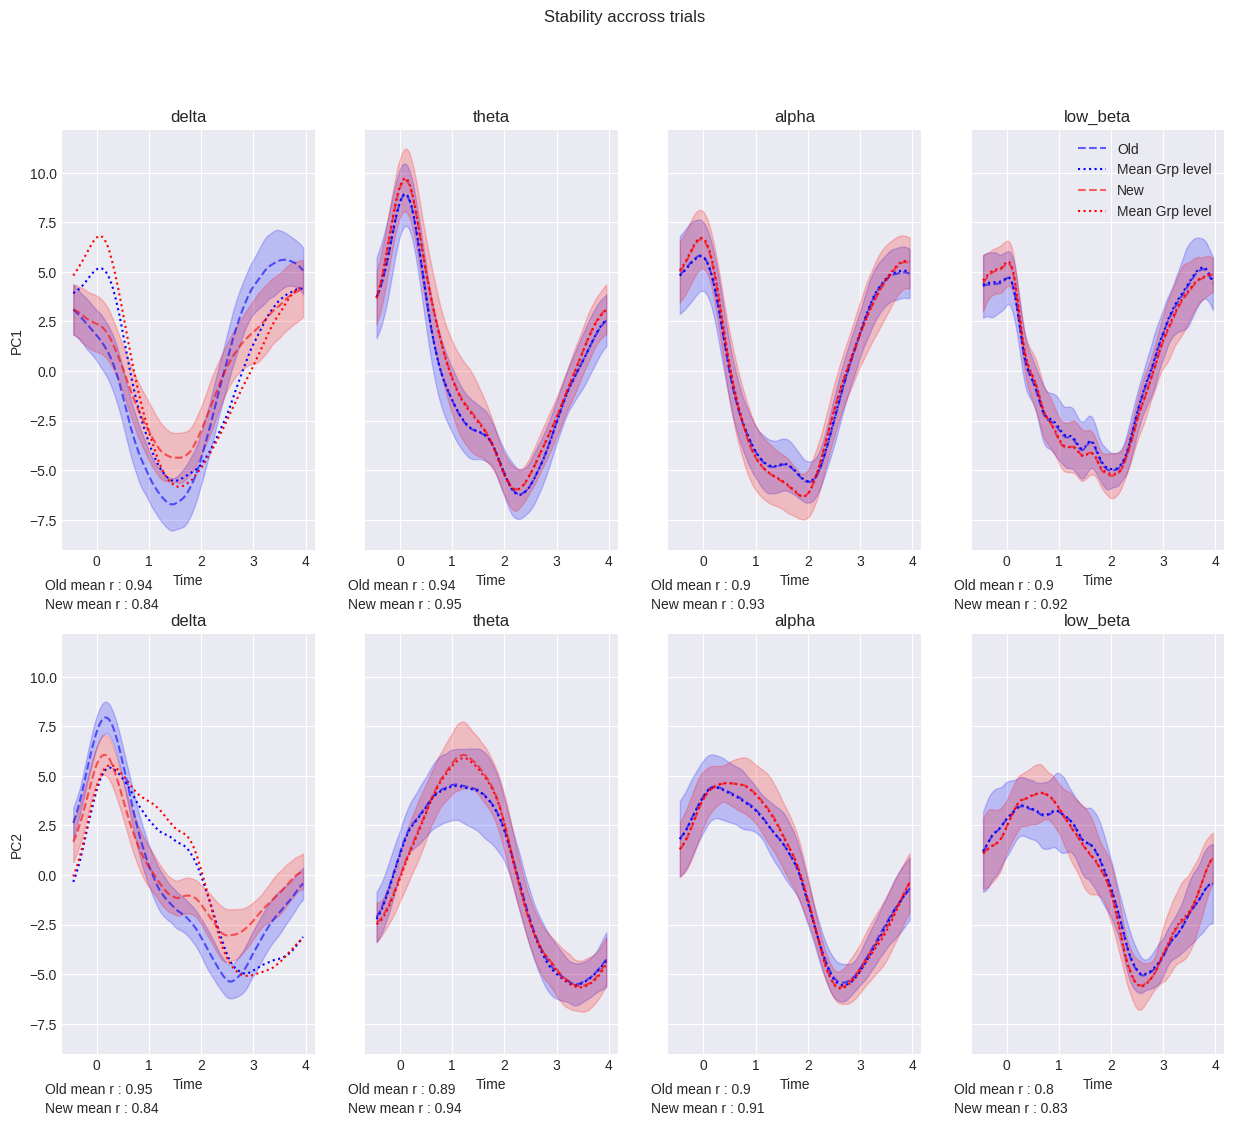

In [93]:
fig, axs= plt.subplots(2, 4, figsize=(15, 12), sharey=True)
fig.suptitle('Stability accross trials')
axs[0][0].set_ylabel('PC1')
axs[1][0].set_ylabel('PC2')

color_event = {0: 'b', 1:'r'}
event_idx = {0: 'Old', 1:'New'}
for PC_use in [0, 1] : 
    for ax, band in zip(axs[PC_use], FREQ_BAND[:4]) :
        X_train, y_train, X_test, y_test, True_trials, pca_weights = DataTransformationM1(freq= band, method_pca=method_pca, data_aug_method=data_aug_method, subj_included=subj_included, PC_use=PC_use, data_path=data_path)        
        X = np.concat([X_train, X_test])
        y = np.concat([y_train, y_test])
        id_old = np.where(y ==1)[0]
        id_new = np.where(y ==2)[0]
        # add copo time serie
        c = 'compo' + str(PC_use + 1)
        time_serie = transform.query('freq == @band and compo == @c').drop(columns = ['Unnamed: 0', 'freq' , 'compo', 'subj', 'expl_var']).values
        if band == 'alpha' and PC_use == 1 : 
            time_serie = - time_serie
            X = -X

        for i_ev,index_  in enumerate([id_old, id_new]) : 
            ax.plot(time, X[index_, :].mean(0), label = event_idx[i_ev], c = color_event[i_ev], ls='--', alpha = 0.6)
            ax.fill_between(time, X[index_, :].mean(0) - X[index_, :].std(0), X[index_, :].mean(0) + X[index_, :].std(0), alpha  = 0.2, color = color_event[i_ev]) 
            
            if i_ev == 0 :
                ax.plot(time, time_serie[0, :int(time_serie.shape[1]/2)], label = 'Mean Grp level', c = color_event[i_ev], alpha = 1, ls=':')
            elif i_ev == 1 : 
                ax.plot(time, time_serie[0, int(time_serie.shape[1]/2):], label = 'Mean Grp level', c = color_event[i_ev], alpha = 1, ls=':')
            
            # compute the corr coef
            corr =np.mean(spearmanr(X[index_, :].T).statistic)
            ax.text(s=f'{event_idx[i_ev]} mean r : {np.round(corr, 2)}', y = -11 - (i_ev), x = -1)

        ax.set_title(band)      
        ax.grid()  
        ax.set_xlabel('Time')
    if PC_use == 0 :
        ax.legend(bbox_to_anchor = (1, 1))


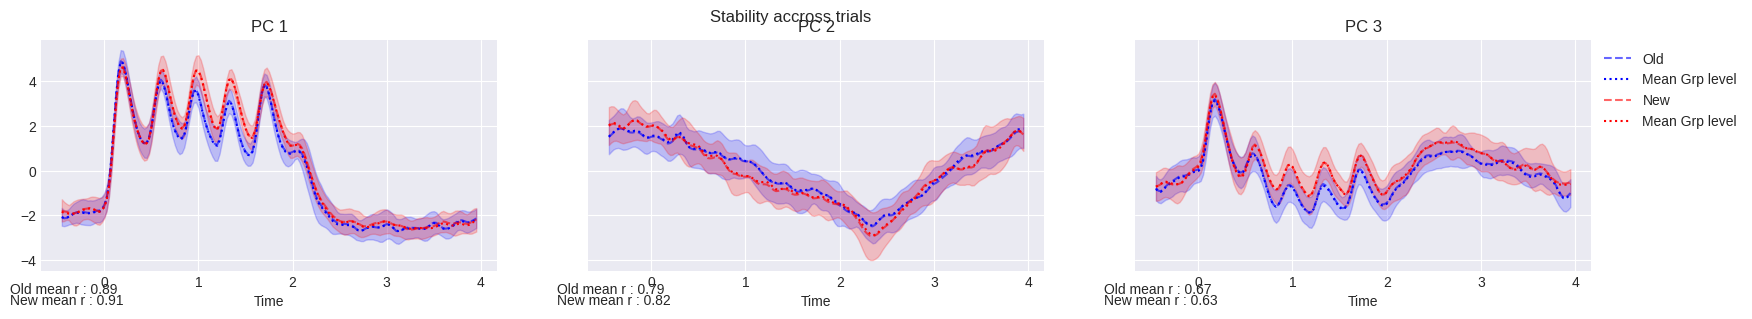

In [107]:
fig, ax= plt.subplots(1, 3, figsize=(20, 3), sharey=True)
fig.suptitle('Stability accross trials')

color_event = {0: 'b', 1:'r'}
event_idx = {0: 'Old', 1:'New'}
band = 'high_gamma'
for PC_use in [0, 1, 2] : 
    X_train, y_train, X_test, y_test, True_trials, pca_weights = DataTransformationM1(freq= band, method_pca=method_pca, data_aug_method=data_aug_method, subj_included=subj_included, PC_use=PC_use, data_path=data_path)        
    X = np.concat([X_train, X_test])
    y = np.concat([y_train, y_test])
    id_old = np.where(y ==1)[0]
    id_new = np.where(y ==2)[0]
    # add copo time serie
    c = 'compo' + str(PC_use + 1)
    time_serie = transform.query('freq == @band and compo == @c').drop(columns = ['Unnamed: 0', 'freq' , 'compo', 'subj', 'expl_var']).values

    for i_ev,index_  in enumerate([id_old, id_new]) : 
        ax[PC_use].plot(time, X[index_, :].mean(0), label = event_idx[i_ev], c = color_event[i_ev], ls='--', alpha = 0.6)
        ax[PC_use].fill_between(time, X[index_, :].mean(0) - X[index_, :].std(0), X[index_, :].mean(0) + X[index_, :].std(0), alpha  = 0.2, color = color_event[i_ev]) 
        
        if i_ev == 0 :
            ax[PC_use].plot(time, time_serie[0, :int(time_serie.shape[1]/2)], label = 'Mean Grp level', c = color_event[i_ev], alpha = 1, ls=':')
        elif i_ev == 1 : 
            ax[PC_use].plot(time, time_serie[0, int(time_serie.shape[1]/2):], label = 'Mean Grp level', c = color_event[i_ev], alpha = 1, ls=':')
        
        # compute the corr coef
        corr =np.mean(spearmanr(X[index_, :].T).statistic)
        ax[PC_use].text(s=f'{event_idx[i_ev]} mean r : {np.round(corr, 2)}', y = -5.5 - 0.5*(i_ev), x = -1)

    ax[PC_use].set_title('PC ' + str(PC_use+1))   
    ax[PC_use].grid()  
    ax[PC_use].set_xlabel('Time')

ax[-1].legend(bbox_to_anchor = (1, 1))

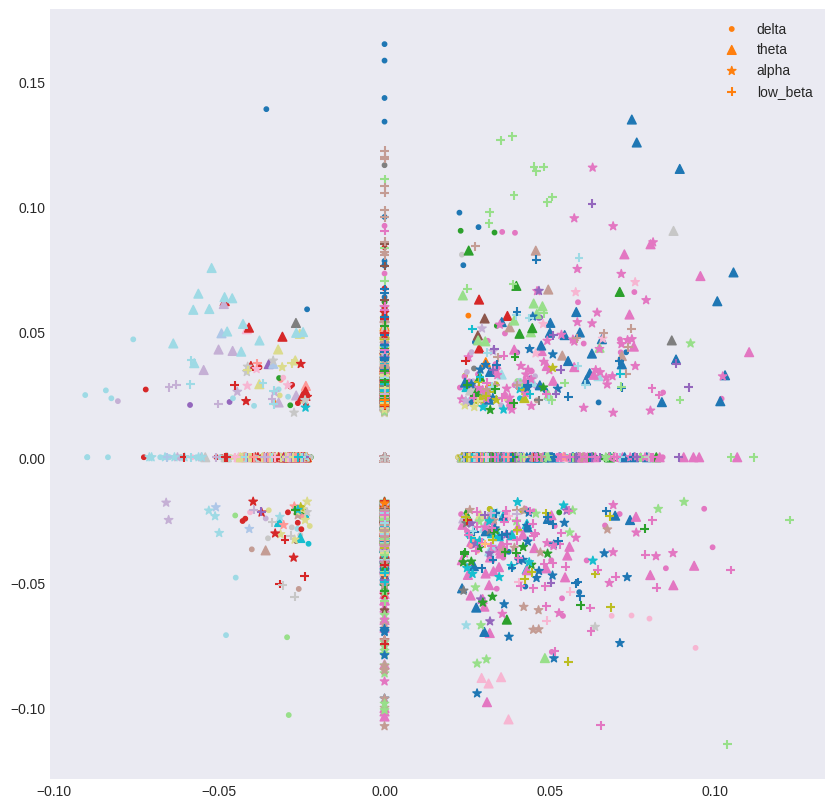

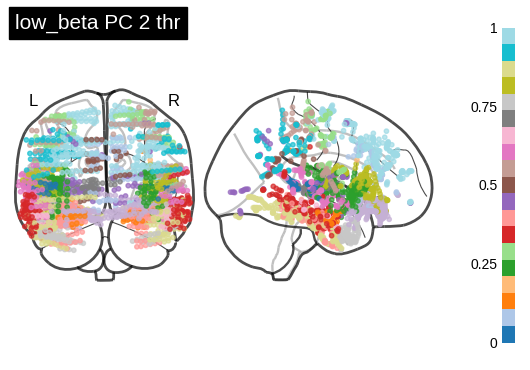

In [90]:
# Binary plot for all the low freq 1 neg wiehgt 2 pos weights
fig, ax =plt.subplots(figsize = (10, 10))
m = {band:mark for band, mark in zip(FREQ_BAND[:4], ['.','^', '*', '+'])}
regions_ = [str(r) for r in regions]
unique_r = np.unique(regions_)
mapper = {reg:num for num, reg in zip(np.arange(len(np.unique(regions_))), unique_r)}
region_code = [mapper[r] for r in regions_]
cmap = plt.get_cmap('tab20')
region_code_norm = (region_code - min(region_code))/(max(region_code) - min(region_code)) 
colors = np.array([cmap(code) for code in region_code_norm])

for band in FREQ_BAND[:4] :
    data = compo.query("freq == @band").drop(columns = ['compo', 'freq']).values
    if band == 'alpha' : 
        data_thr[1,:] = -data_thr[1,:] # flip compo 2 alpha
    
    data_thr = CompoThr(data, replace=0)
    ax.scatter(data_thr[0,:], data_thr[1, :], s=40, marker=m[band], c=colors,label =band )

ax.legend()

fig = plotting.plot_markers(node_coords = np.array(coord),  node_size=10, node_values=region_code_norm,
                                node_cmap= cmap, title=band +f' PC {PC_use+1} thr',display_mode='yx')



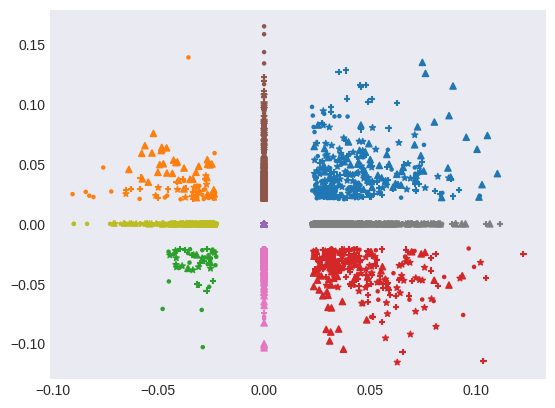

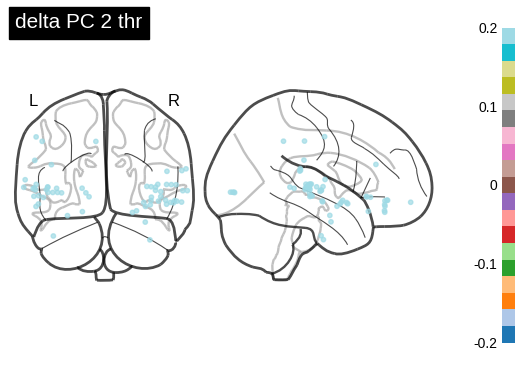

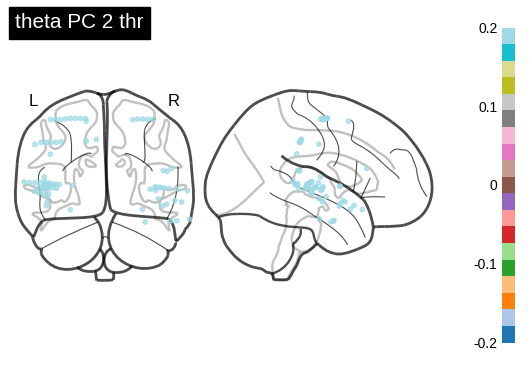

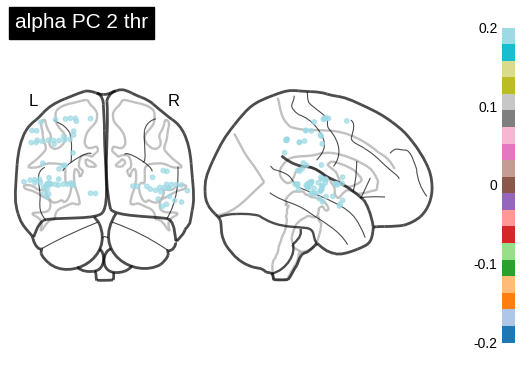

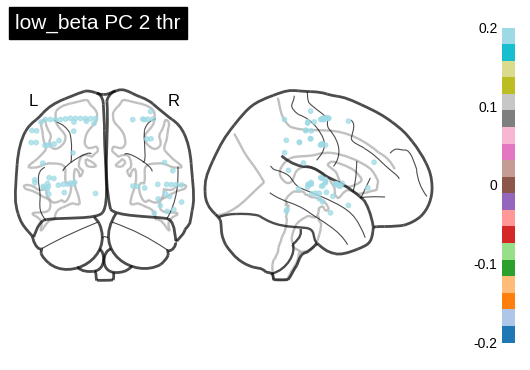

In [86]:
cmap = plt.get_cmap('tab20')
mapper_colors = {num:cmap(num/10) for num in range(9)}

fif, ax = plt.subplots()
for band in FREQ_BAND[:4] :
    data = compo.query("freq == @band").drop(columns = ['compo', 'freq']).values
    if band == 'alpha' : 
        data[1,:] = -data[1,:] # flip compo 2 alpha
    
    data_thr = CompoThr(data, replace=0)
    x = data_thr[0, :]
    y = data_thr[1, :]

    # Quadrant-based colors
    colors = []
    for xi, yi in zip(x, y):
        if xi > 0 and yi > 0:
            colors.append(0)          # Q1: both positive
        elif xi < 0 and yi > 0:
            colors.append(1)         # Q2: x negative, y positive
        elif xi < 0 and yi < 0:
            colors.append(2) 
        elif xi > 0 and yi < 0  :
            colors.append(3)    # Q3: both negative
        elif xi == 0 and yi == 0 :
            colors.append(4)
        elif xi ==0 and yi > 0 :
            colors.append(5)
        elif xi ==0 and yi < 0 :
            colors.append(6)
        elif xi >0 and yi == 0 :
            colors.append(7)
        elif xi < 0 and yi == 0 :
            colors.append(8)
    ax.scatter(data_thr[0,:], data_thr[1, :], s=20, marker=m[band],label =band , c=[mapper_colors[c] for c in colors])

    to_plot_id = np.where(np.array(colors) == 0)[0]
    fig = plotting.plot_markers(node_coords = np.array(coord)[to_plot_id],  node_size=10, node_values=[1]*len(to_plot_id),
                                node_cmap= cmap, title=band +f' PC {PC_use+1} thr',display_mode='yx', node_vmax=0.2, node_vmin=-0.2)



In [11]:
import matplotlib as mpl
cmap = plt.get_cmap('tab20')
bounds = np.arange(len(unique_r) + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(1, len(unique_r)))

# Create colorbar as a legend
cb = mpl.colorbar.ColorbarBase(
    ax, cmap=cmap, norm=norm, boundaries=bounds,
    ticks=(bounds[:-1] + bounds[1:]) / 2,    # center ticks
    orientation='vertical'
)

cb.ax.set_yticklabels(unique_r)
#plt.show()
plt.close()


/tmp/ipykernel_28323/2854155000.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(np.array(regions)[to_plot_id], ax=axs, kde = True, palette=element_colors[band], label = band)
/tmp/ipykernel_28323/2854155000.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(np.array(regions)[to_plot_id_pos], ax=ax[0], kde = True, palette=element_colors[band], label = band)
/tmp/ipykernel_28323/2854155000.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(np.array(regions)[to_plot_id_neg], ax=ax[1], kde = True, palette=element_colors[band], label = band)
/tmp/ipykernel_28323/2854155000.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels = ax[0].get_xticklabels(), rotation = 90)
/tmp/ipykernel_28323/2854155000.py:28: UserWarning: set_ticklabels() s

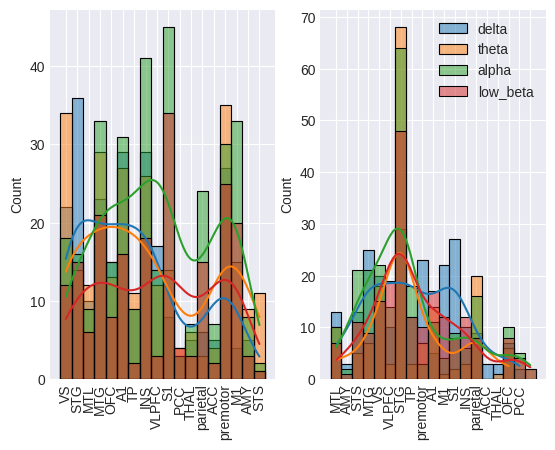

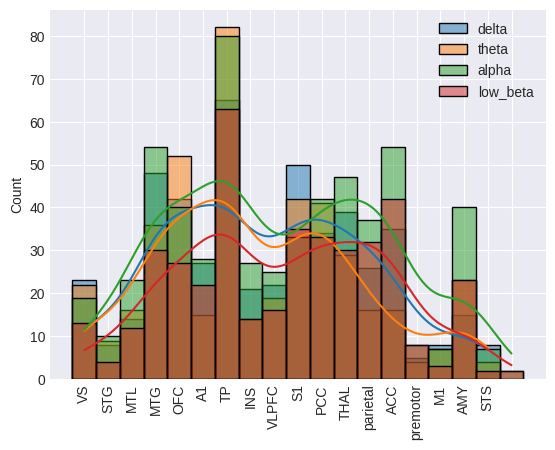

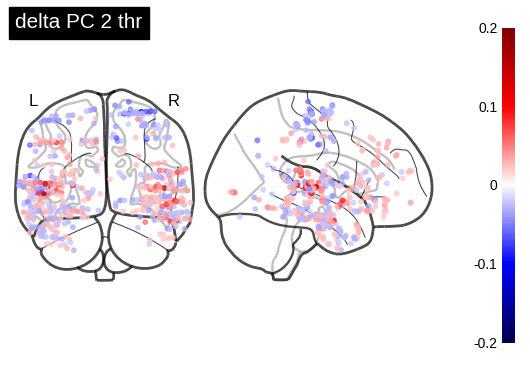

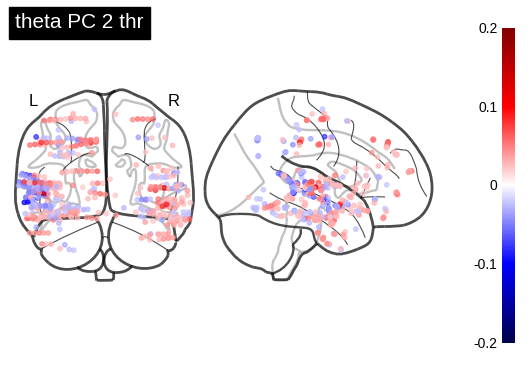

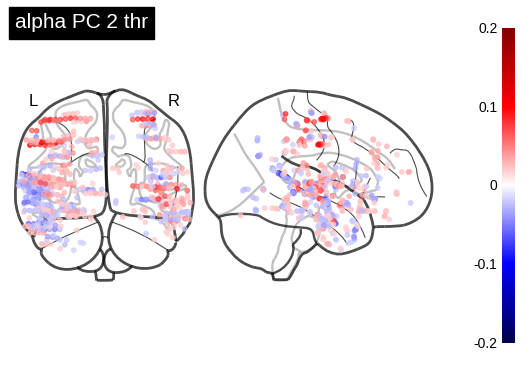

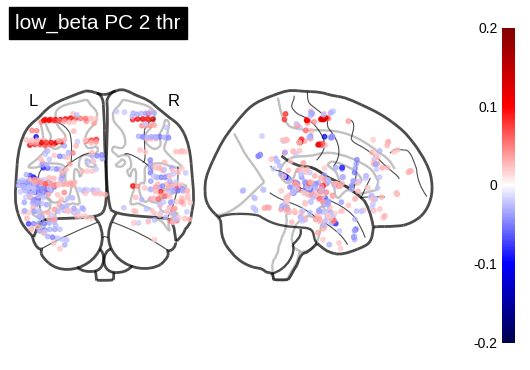

In [24]:
# Binary plot for all the low freq 1 neg wiehgt 2 pos weights
fig, ax=plt.subplots(1, 2)
fig, axs=plt.subplots()

PC_use = 1
cmap = plt.get_cmap('seismic')
for band in FREQ_BAND[:4] : 
    data = compo.query("freq == @band").drop(columns = ['compo', 'freq']).values
    data_thr = CompoThr(data, replace=0)
    if band == 'alpha' : 
        data_thr[1,:] = -data_thr[1,:] # flip compo 2 alpha
    
    to_plot_id = np.where(data_thr[PC_use, :] != 0)[0]
    to_plot = (data_thr[PC_use, to_plot_id] - data_thr[PC_use, to_plot_id].min())/ (data_thr[PC_use, to_plot_id].max() - data_thr[PC_use, to_plot_id].min())
    colors_1 = np.array([cmap(code) for code in to_plot])
    #view = plotting.view_markers(np.array(coord)[to_plot_id],marker_color=colors_1,marker_size=8,title=band +' PC1 thr',title_fontsize=25, marker_labels='')
    #view.open_in_browser()
    fig = plotting.plot_markers(node_coords = np.array(coord)[to_plot_id],  node_size=10, node_values=data_thr[PC_use, to_plot_id], 
                                node_cmap= 'seismic', title=band +f' PC {PC_use+1} thr',display_mode='yx', node_vmax=0.2, node_vmin=-0.2)

    sns.histplot(np.array(regions)[to_plot_id], ax=axs, kde = True, palette=element_colors[band], label = band)
    to_plot_id_pos = np.where(data_thr[PC_use, :] > 0)[0]
    sns.histplot(np.array(regions)[to_plot_id_pos], ax=ax[0], kde = True, palette=element_colors[band], label = band)
    to_plot_id_neg = np.where(data_thr[PC_use, :] < 0)[0]
    sns.histplot(np.array(regions)[to_plot_id_neg], ax=ax[1], kde = True, palette=element_colors[band], label = band)

    ax[0].set_xticklabels(labels = ax[0].get_xticklabels(), rotation = 90)
    ax[1].set_xticklabels(labels = ax[1].get_xticklabels(), rotation = 90)
    axs.set_xticklabels(labels = ax[0].get_xticklabels(), rotation = 90)

axs.grid()
axs.legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()


In [ ]:
view = plotting.view_markers(np.array(coord)[to_plot_id],marker_color=colors_1,marker_size=8,title=band +'PC1 thr',title_fontsize=25, marker_labels='')
view.open_in_browser()

In [ ]:
# Compo cluster comparison 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score
# model to try 
models = [KMeans, SpectralClustering, AgglomerativeClustering]
names =  ['KMeans', 'SpectralClustering', 'AgglomerativeClustering']

df_labels =pd.DataFrame()
for band in FREQ_BAND[:3] :
    data = compo.query("freq == @band").drop(columns = ['compo', 'freq']).values
    weight_data_b = CompoThr(data, replace = 0).T
    df= pd.DataFrame(weight_data_b[:, 0]).rename(columns = {0: 'compo1'})
    df.loc[:, 'compo2'] = weight_data_b[:, 1]
    df.loc[:, 'compo3'] = weight_data_b[:, 2]
    df['area'] = [a[0] for a in areas]

    scaler = StandardScaler(with_std=False, with_mean=False)
    weight_data_b = scaler.fit_transform(weight_data_b)[:,:2]

    
    for name, model in zip(names, models) : 
        silhouette_avg = []
        range_n_clusters = np.arange(2, 10)
        for n_clusters in range_n_clusters : 
            cl = model(n_clusters)
            cl.fit(weight_data_b)
            cluster_labels = cl.labels_
            silhouette_avg.append(silhouette_score(weight_data_b, cluster_labels))
        ncl_best = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
        sil_score = max(silhouette_avg)

        m = model(ncl_best).fit(weight_data_b)
        df['label_' + name] = m.labels_.T
        df_labels[band + '_' +name] =  m.labels_.T

        for ic, c in enumerate(['compo1', 'compo2']) : 
            df_labels[band + '_' + c]= weight_data_b[:,ic ]

In [ ]:
df_labels.to_csv(OUT_PATH + '/grpPCA/supsubj_concat/labelsTHR.csv')

In [25]:
df_labels = pd.read_csv(OUT_PATH + '/grpPCA/supsubj_concat/labelsTHR.csv')

/tmp/ipykernel_28323/2291644717.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(x=df_labels[band + '_compo1'], y=df_labels[band + '_compo2'], hue = df_labels[band + '_' + mode], ax=ax[ib], palette=colors, s= 20, alpha = 1)
/tmp/ipykernel_28323/2291644717.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(x=df_labels[band + '_compo1'], y=df_labels[band + '_compo2'], hue = df_labels[band + '_' + mode], ax=ax[ib], palette=colors, s= 20, alpha = 1)
/tmp/ipykernel_28323/2291644717.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(x=df_labels[band + '_compo1'], y=df_labels[band + '_compo2'], hue = df_labels[band + '_' + mode], ax=ax[ib], palette=colors, s= 2

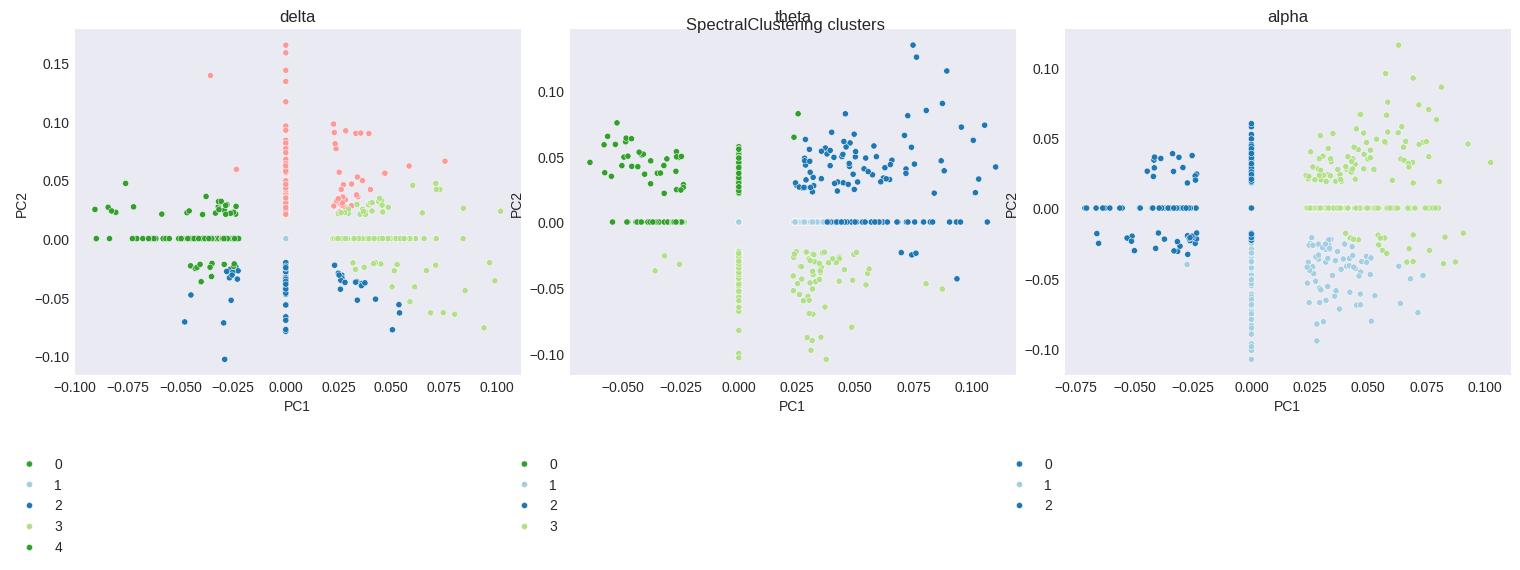

In [62]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
fig.tight_layout()

mode = 'SpectralClustering'
fig.suptitle(f'{mode} clusters')
cmap = plt.get_cmap('Paired')

for ib, band in enumerate(FREQ_BAND[:3]):
    colors = np.array([cmap(code) for code in np.unique(df_labels[band + '_'+mode])])
    sns.scatterplot(x=df_labels[band + '_compo1'], y=df_labels[band + '_compo2'], hue = df_labels[band + '_' + mode], ax=ax[ib], palette=colors, s= 20, alpha = 1)
    ax[ib].set_title(band)
    ax[ib].set_xlabel('PC1')
    ax[ib].set_ylabel('PC2')
    ax[ib].legend(np.unique(df_labels[band + '_'+mode]), bbox_to_anchor = (0, -0.2),)


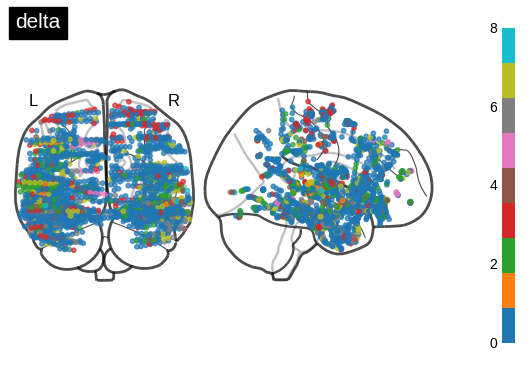

In [28]:
band = 'delta'
labs = df_labels[df_labels[band + '_KMeans'] == 
fig1 = plotting.plot_markers(node_coords = np.array(coord),  node_size=10, node_values=df_labels[band + '_KMeans'],title=band, node_cmap='tab10',display_mode='yx')

## High gamma specific

3 componants desciptions: topo + kmean in 3D loc the hubs +  \
3 time course description: cross freq analysis \
Decoding on the 3 componants all + wights, time points + weight, temporal generalization 


# PAPER 2

## broadband + BROADNESS + RQA + Kmeans